In [1]:
import argparse
import math
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_
from src.gradient_masking_tests import gradient_norm, fgsm_pgd_cos_dif, multi_scale_fgsm
import eagerpy as ep
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, ResNet18GradReg
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers, src.gradient_masking_tests

In [2]:
# setup
device = torch.device("cuda")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load CIFAR-10 models

In [3]:
# # Regular CIFAR-10  ResNet Model
model = CIFAR_Res_Net(device).eval()
model.load_state_dict(torch.load("../models/cifar_res_net.model"))
# CIFAR-10  ResNet Model trained with large FGSM steps
fgsm_model = CIFAR_Res_Net(device).eval()
fgsm_model.load_state_dict(torch.load("../models/cifar_res_net_fgsm06.model"))
# # # CIFAR-10  ResNet Model trained with small FGSM steps
fgsm_model_small = CIFAR_Res_Net(device).eval()
fgsm_model_small.load_state_dict(torch.load("../models/cifar_res_net_20e_fgsm03.model"))
# # # CIFAR-10  ResNet Model trained with large Step-ll steps
step_ll_model = CIFAR_Res_Net(device).eval()
step_ll_model.load_state_dict(torch.load("../models/cifar_res_net_20e_stepll.model"))
# # CIFAR-10  ResNet Model trained through input gradient regularization ld2
gradient_norm_model = CIFAR_Res_Net(device).eval()
gradient_norm_model.load_state_dict(torch.load("../models/cifar_res_net_grad_reg_20e_ld2.model"))
# # CIFAR-10  ResNet Model trained through input gradient regularization ld5
gradient_norm_model_strong = CIFAR_Res_Net(device).eval()
gradient_norm_model_strong.load_state_dict(torch.load("../models/cifar_res_net_grad_reg_20e_ld5.model"))

<All keys matched successfully>

### Check gradient norms
Gradients seem to blow up after FGSM training

In [8]:
subset_size = 5000
train_subset = torch.utils.data.Subset(train_dataset, np.random.randint(0, len(train_dataset), size=subset_size).tolist())
train_subset_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

test_subset = torch.utils.data.Subset(test_dataset, np.random.randint(0, len(test_dataset), size=subset_size).tolist())
test_subset_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

In [9]:
def show_grad_histogram(model, data_loader, device='cpu'):
    norm = gradient_norm(model, data_loader, device=device).detach().cpu().numpy()
    plt.hist(norm, bins=100)
    plt.show()
    print("Max: {}, Min: {}, Mean: {}, Median: {}".format(norm.max(), norm.min(), norm.mean(), np.median(norm)))

def compare_models_grad(models, labels, data_loader, device='cpu', height=2):
    norms = [gradient_norm(model, data_loader, device=device).detach().cpu().numpy() for model in models]
    width = math.ceil(len(models)/height)
    fig, ax = plt.subplots(height, width, figsize=(15, 15))
    for index, norm in enumerate(norms):
        axis = ax[index//width, index%width]
        axis.hist(norm, bins=100)
        axis.set_title(labels[index])
        axis.text(0.5, -0.13, "Max: {:.6f}, Min: {:.6f}, \nMean: {:.6f}, Median: {:.6f}".format(norm.max().item(), norm.min().item(), norm.mean().item(), np.median(norm).item()),
                                            size=12, ha="center", transform=axis.transAxes)
    plt.show()

### Using train dataset

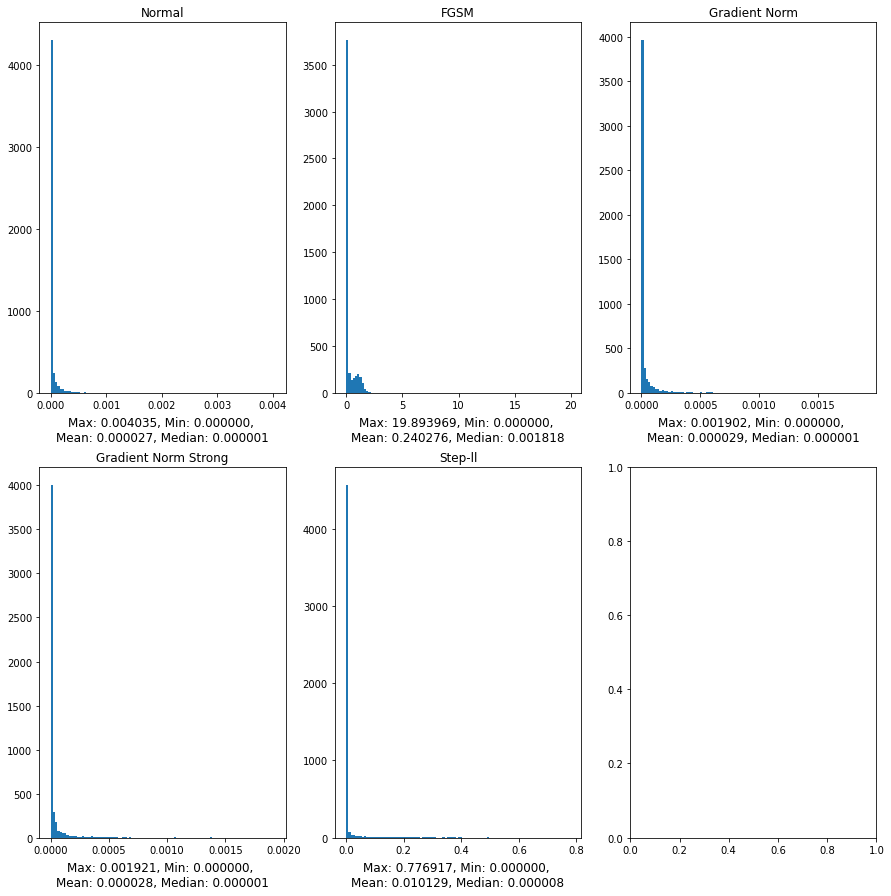

In [10]:
compare_models_grad([model, fgsm_model, gradient_norm_model, gradient_norm_model_strong, step_ll_model], ['Normal', 'FGSM', 'Gradient Norm', 'Gradient Norm Strong', 'Step-ll'], train_subset_loader, device=device, height=2)

### Using test dataset

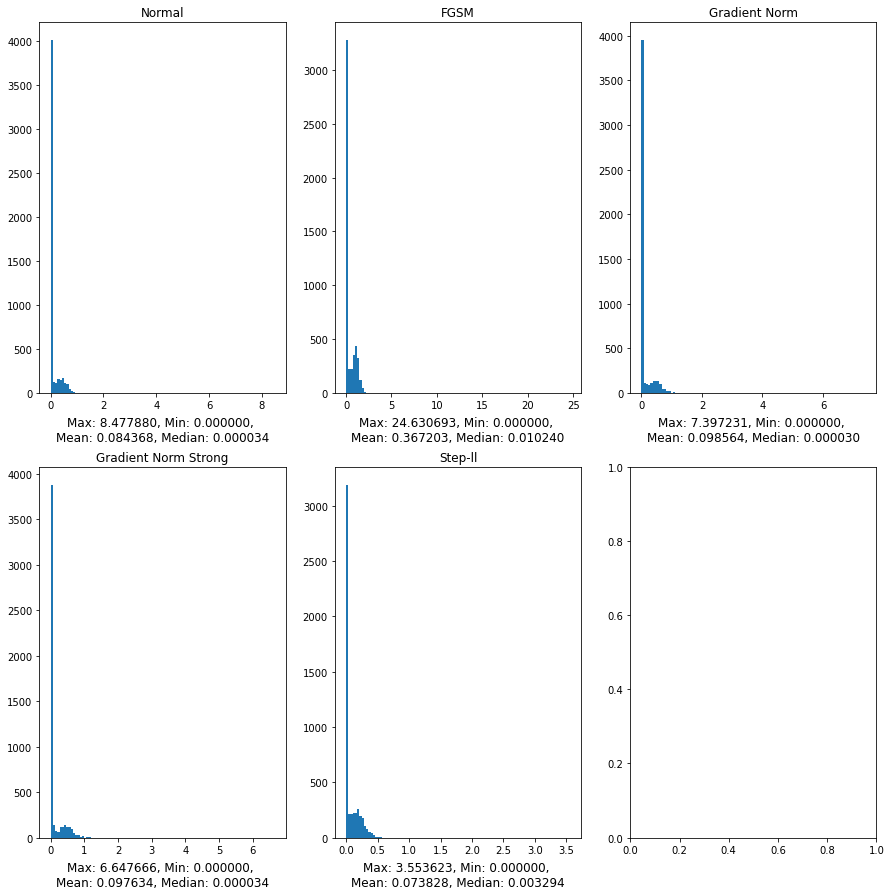

In [11]:
compare_models_grad([model, fgsm_model, gradient_norm_model, gradient_norm_model_strong, step_ll_model], ['Normal', 'FGSM', 'Gradient Norm', 'Gradient Norm Strong', 'Step-ll'], test_subset_loader, device=device, height=2)

### Using train dataset

#### Normal model

In [16]:
fgsm_pgd_cos_dif(model, train_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002203787A820>
Traceback (most recent call last):
  File "D:\Anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "D:\Anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\data\dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "D:\Anaconda3\envs\pytorch-env\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "D:\Anaconda3\envs\pytorch-env\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

#### FGSM Model

In [ ]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(fgsm_model, train_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)

#### Gradient Regularization Model

In [7]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model, train_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.19814883172512054, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.11878497153520584, Mean l2 Distance: 3.7859671115875244
FGSM success: 0.9771999716758728, PGD Success: 1.0, Rescaled FGSM success: 0.9757999777793884


### Gradient Regularization Strong Model 

In [8]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model_strong, train_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.2119116187095642, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.14365004003047943, Mean l2 Distance: 3.769777297973633
FGSM success: 0.9805999994277954, PGD Success: 1.0, Rescaled FGSM success: 0.9763999581336975


#### Step-ll Model

In [9]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(step_ll_model, train_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.1382458657026291, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.12352241575717926, Mean l2 Distance: 3.8619272708892822
FGSM success: 0.005200000014156103, PGD Success: 0.9929999709129333, Rescaled FGSM success: 0.0026000000070780516


### Using test dataset

#### Normal Model

In [10]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(model, test_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.2236652970314026, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.15124349296092987, Mean l2 Distance: 3.740572929382324
FGSM success: 0.977400004863739, PGD Success: 1.0, Rescaled FGSM success: 0.9733999967575073


#### FGSM Model

In [11]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(fgsm_model, test_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.033388372510671616, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.030080262571573257, Mean l2 Distance: 3.911848783493042
FGSM success: 0.14899998903274536, PGD Success: 1.0, Rescaled FGSM success: 0.14019998908042908


#### Gradient Regularization Model

In [12]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model, test_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.21285565197467804, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.10542367398738861, Mean l2 Distance: 3.7488749027252197
FGSM success: 0.9801999926567078, PGD Success: 1.0, Rescaled FGSM success: 0.9769999980926514


### Gradient Regularization Model Strong

In [13]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model_strong, test_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.22810329496860504, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.17191214859485626, Mean l2 Distance: 3.729104518890381
FGSM success: 0.9835999608039856, PGD Success: 1.0, Rescaled FGSM success: 0.9799999594688416


#### Step-ll Model

In [14]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(step_ll_model, test_dataset, epsilons=[0.03, 0.06], device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)


Mean Cosine Difference: 0.1331690400838852, Mean Cosine Difference when FGSM does not succeed but PGD does: 0.13038218021392822, Mean l2 Distance: 3.846073627471924
FGSM success: 0.4351999759674072, PGD Success: 0.9945999979972839, Rescaled FGSM success: 0.40219998359680176
